In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
spark = SparkSession.builder.appName("Processing_Data").getOrCreate()

In [3]:
print("spark version = ", spark.version)

spark version =  3.5.0


In [13]:
#Get the UI weburl for spark session:

print("spark version = ", spark.sparkContext.uiWebUrl)

spark version =  http://DESKTOP-JLC36MP:4040


<hr>
<hr>

## Spark submit: Executor, Core, memory

### let say Spark cluster is having 5 nodes with each node of 12 cores, 48 GB RAM then:

## 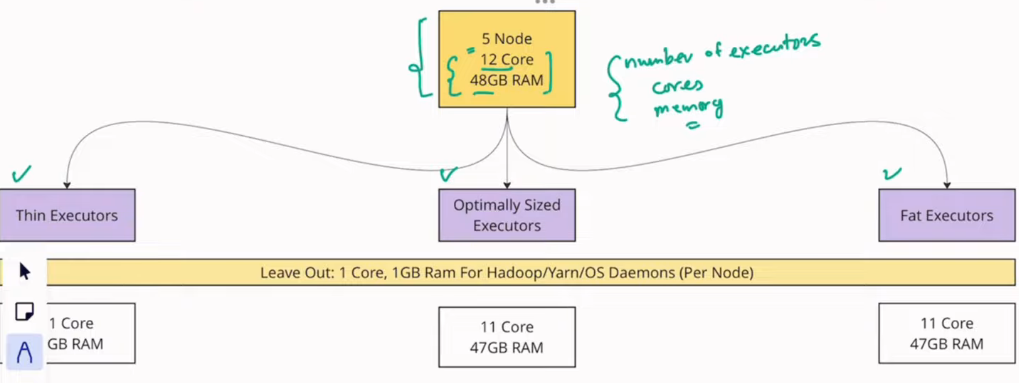

## 1). Fat executor:


#### memory wise
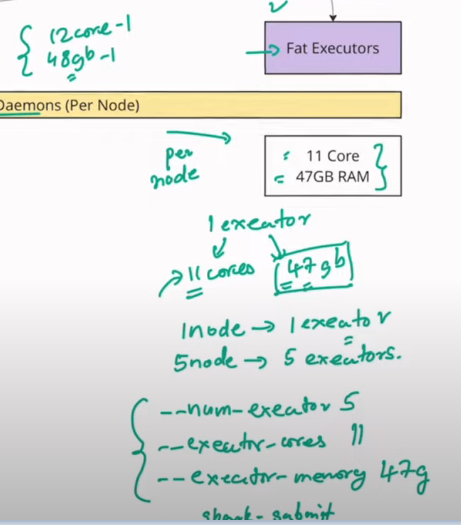

#### Advantages vs Disadvantages
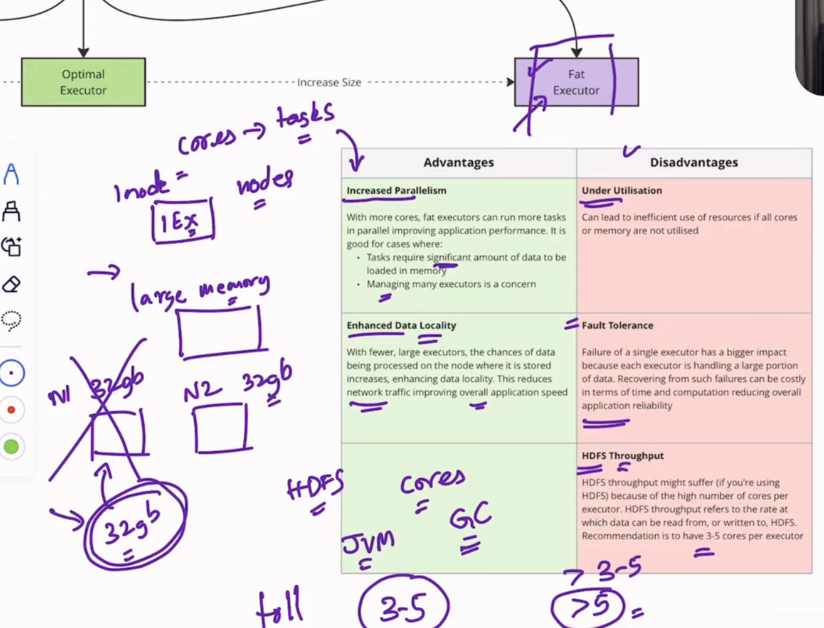

## 2). Thin Executor:

#### Memory wise:
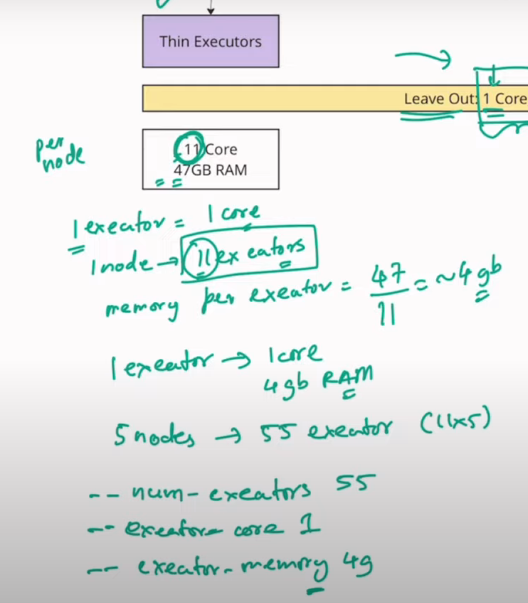


#### Advantages vs Disadvantages
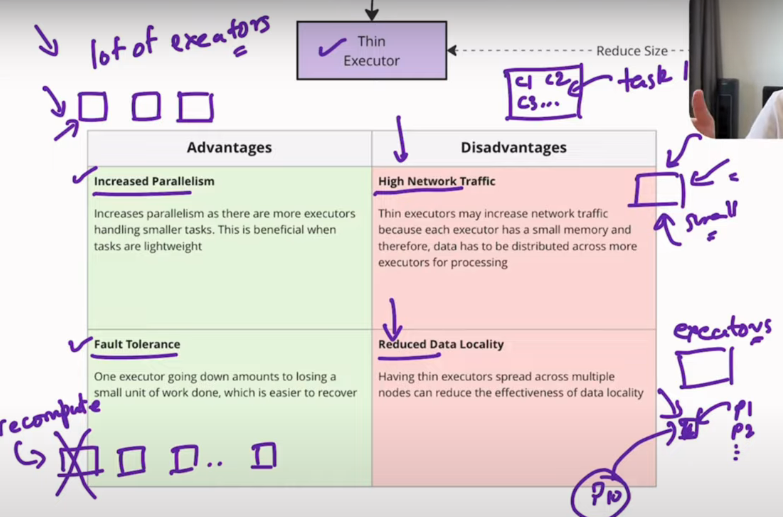

## 3). Optimally sized executors:

#### High level info:
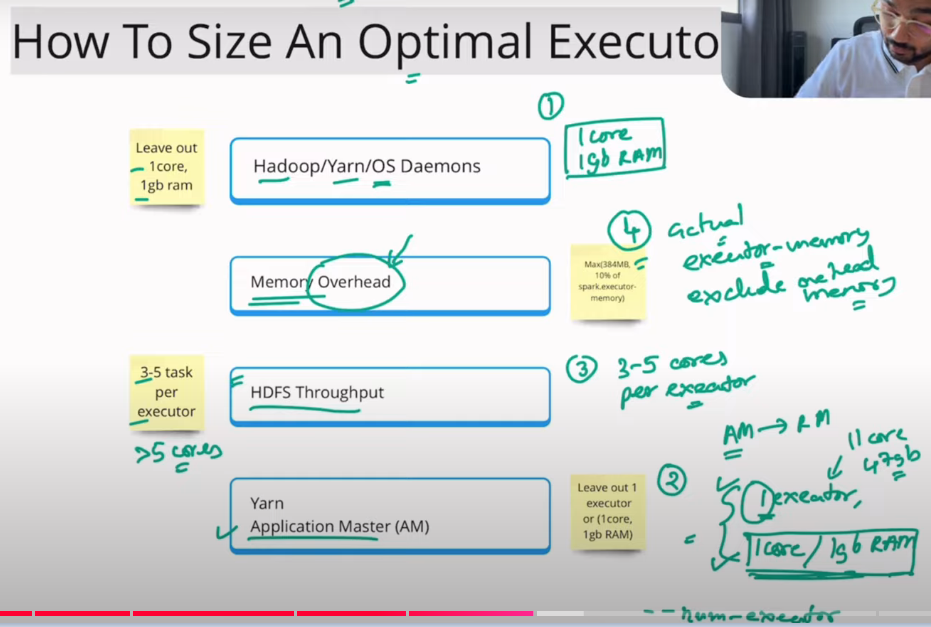

#### More granular level of memory: (no need to care of input data size 10GB or 100GB file)
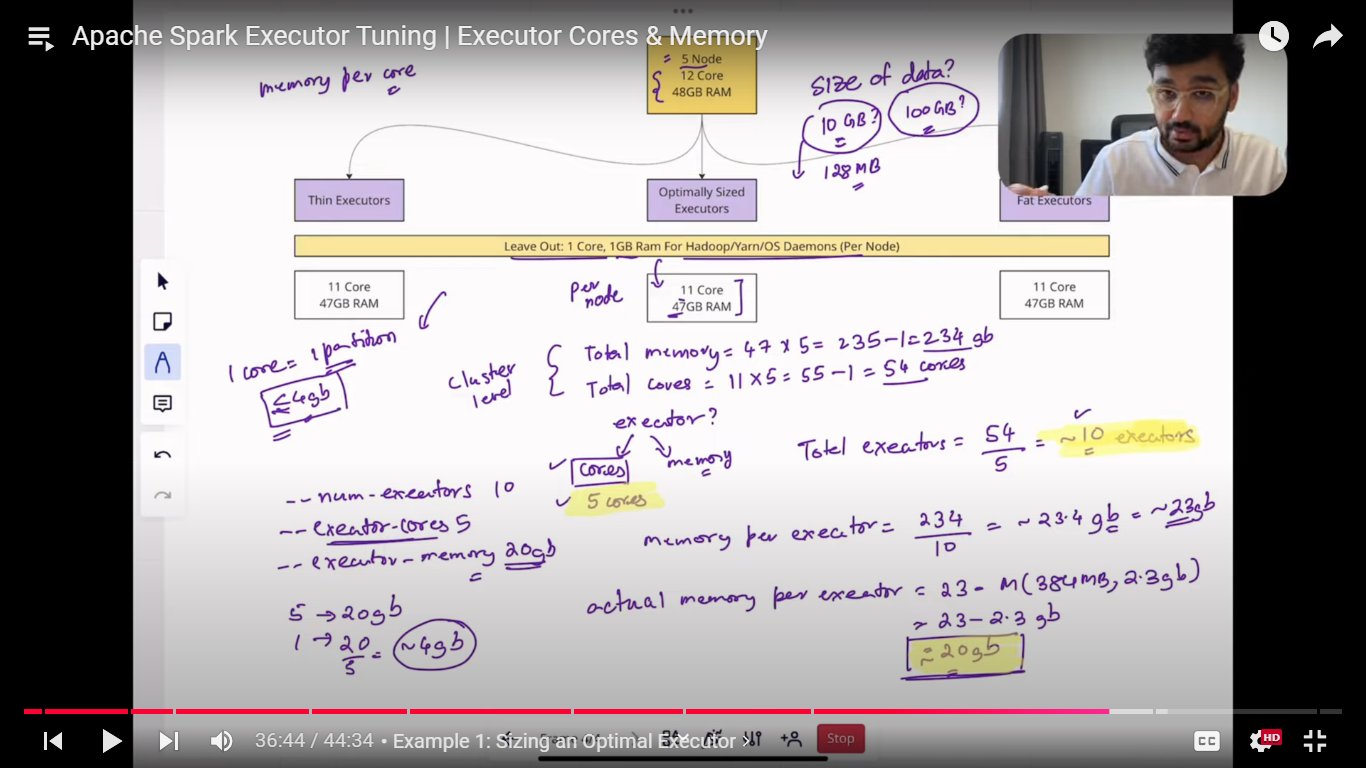

## Example 2: For Optimal executor details for spark_submit:

#### 3 nodes each 16 core, 48GB RAM
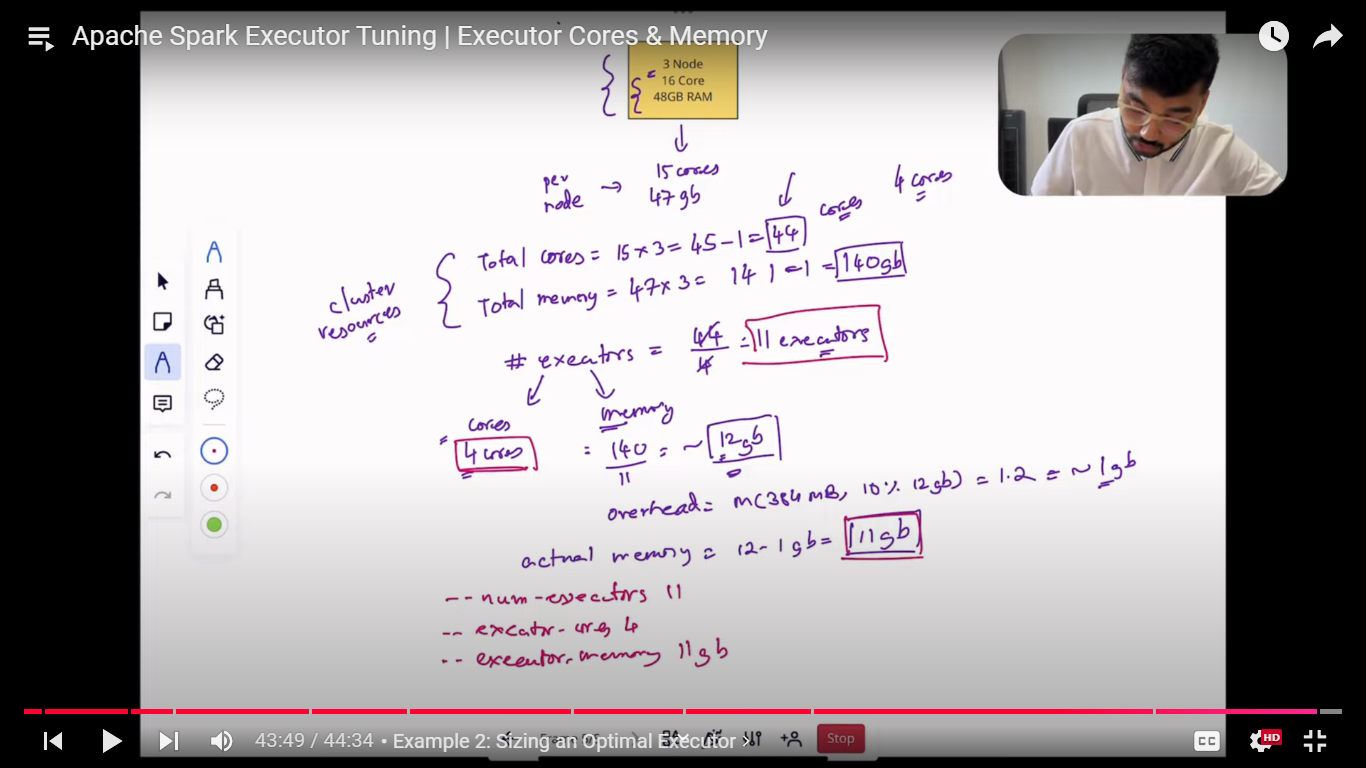

# Pivot() in pyspark

### Q). Convert normal table to pivot in pyspark:

In [9]:
# Given dataset:
_data = [
["SURENDRA", "PHY", 90],
["SURENDRA", "MATH", 95],
["SURENDRA", "CHEM", 100],
["KALYAN", "PHY", 90],
["KALYAN", "MATH", 100],
["KALYAN", "CHEM", 83],
["SAI", "BIO", 90],
["SAI", "MATH", 70],
["SAI", "CHEM", 76],
["GANESH", "PHY", 96],
["GANESH", "MATH", 87],
["GANESH", "CHEM", 79],
["GANESH", "BIO", 82]
]

_cols = ["NAME", "SUBJECT", "MARKS"]

df =  spark.createDataFrame(_data, schema = _cols)
df.show()

+--------+-------+-----+
|    NAME|SUBJECT|MARKS|
+--------+-------+-----+
|SURENDRA|    PHY|   90|
|SURENDRA|   MATH|   95|
|SURENDRA|   CHEM|  100|
|  KALYAN|    PHY|   90|
|  KALYAN|   MATH|  100|
|  KALYAN|   CHEM|   83|
|     SAI|    BIO|   90|
|     SAI|   MATH|   70|
|     SAI|   CHEM|   76|
|  GANESH|    PHY|   96|
|  GANESH|   MATH|   87|
|  GANESH|   CHEM|   79|
|  GANESH|    BIO|   82|
+--------+-------+-----+



In [10]:
# convert above dataset into pivot table 

df2 = df.groupBy("NAME").pivot("SUBJECT").agg(sum("MARKS"))
df2.show()

+--------+----+----+----+----+
|    NAME| BIO|CHEM|MATH| PHY|
+--------+----+----+----+----+
|  KALYAN|NULL|  83| 100|  90|
|SURENDRA|NULL| 100|  95|  90|
|  GANESH|  82|  79|  87|  96|
|     SAI|  90|  76|  70|NULL|
+--------+----+----+----+----+



# Explode()

### Q). Convert list of values in a single row to multiple rows. 

In [19]:
#GIven Data:
df = spark.createDataFrame([(1,["A", "B", "C"]), (2, ["X", "Y", "Z"])], ["ID", "Name"])
df.show()

+---+---------+
| ID|     Name|
+---+---------+
|  1|[A, B, C]|
|  2|[X, Y, Z]|
+---+---------+



In [20]:
#Using explode() function we can convert into multiple rows
df.select("ID", explode("Name").alias("Names")).show()

+---+-----+
| ID|Names|
+---+-----+
|  1|    A|
|  1|    B|
|  1|    C|
|  2|    X|
|  2|    Y|
|  2|    Z|
+---+-----+



### Q). Word count program by reading txt file

In [59]:
#Given Data - same as below cell

#Read using Dataframe API , truncate=False means it will show full content of each row.
df = spark.read.text("Input_Files_Pyspark/pyspark_textfile.txt").show(truncate=False)

#Herre by default "value" column will come if you read textfile using dataframe API

+----------------------------+
|value                       |
+----------------------------+
|Hello world hello computer  |
|Laptop mouse keyboard laptop|
|hello monitor               |
+----------------------------+



In [124]:
#Given Data - same as above cell

#Read using RDD API - same as above
rdd = spark.sparkContext.textFile("Input_Files_Pyspark/pyspark_textfile.txt")
rdd.collect()

['Hello world hello computer ',
 'Laptop mouse keyboard laptop',
 'hello monitor']

In [125]:
type(rdd)

pyspark.rdd.RDD

In [128]:
#use flatMap(), map(), reduceByKey(), split(), lambda functions

rdd2 = rdd.flatMap(lambda line: line.split(" "))
rdd3 = rdd2.map(lambda word: (word.lower(), 1))
rdd4 = rdd3.reduceByKey(lambda a,b: a+b)

#or combined all above 3 steps in single line: So rdd4, rdd5 are same.
rdd5 = rdd.flatMap(lambda x: x.split()).map(lambda x:(x.lower(), 1)).reduceByKey(lambda x,y: x+y)

In [129]:
#check above each rdd's data: rdd2, rdd3, rdd4

print("\n -> rdd2.collect(): \n", rdd2.collect())
print("\n\n -> rdd3.collect(): \n", rdd3.collect())
print("\n\n -> rdd4.collect(): (note: rdd4, rdd5 are same) \n", rdd4.collect())
print("\n\n -> rdd5.collect(): (note: rdd4, rdd5 are same) \n", rdd5.collect())


 -> rdd2.collect(): 
 ['Hello', 'world', 'hello', 'computer', '', 'Laptop', 'mouse', 'keyboard', 'laptop', 'hello', 'monitor']


 -> rdd3.collect(): 
 [('hello', 1), ('world', 1), ('hello', 1), ('computer', 1), ('', 1), ('laptop', 1), ('mouse', 1), ('keyboard', 1), ('laptop', 1), ('hello', 1), ('monitor', 1)]


 -> rdd4.collect(): (note: rdd4, rdd5 are same) 
 [('hello', 3), ('world', 1), ('', 1), ('laptop', 2), ('computer', 1), ('mouse', 1), ('keyboard', 1), ('monitor', 1)]


 -> rdd5.collect(): (note: rdd4, rdd5 are same) 
 [('hello', 3), ('world', 1), ('laptop', 2), ('computer', 1), ('mouse', 1), ('keyboard', 1), ('monitor', 1)]


In [132]:
#convert above rdd into some Dataframe type

df = spark.createDataFrame(rdd4, schema = ["Word", "Count"])
df.orderBy("Count", ascending=False).show()

+--------+-----+
|    Word|Count|
+--------+-----+
|   hello|    3|
|  laptop|    2|
|computer|    1|
|   world|    1|
|   mouse|    1|
|        |    1|
|keyboard|    1|
| monitor|    1|
+--------+-----+



### Q). Difference between flatMap(), map()

In [133]:
#Given data:

rdd = spark.sparkContext.textFile("Input_Files_Pyspark/pyspark_textfile.txt")
rdd.collect()

['Hello world hello computer ',
 'Laptop mouse keyboard laptop',
 'hello monitor']

In [134]:
#use map(): mapping is not flatten

rdd_map = rdd.map(lambda x: x.split(" "))
rdd_map.collect()

[['Hello', 'world', 'hello', 'computer', ''],
 ['Laptop', 'mouse', 'keyboard', 'laptop'],
 ['hello', 'monitor']]

In [136]:
#use flatMap() to flatten the nested lists:

rdd_flatMap = rdd.flatMap(lambda x: x.split(" "))
rdd_flatMap.collect()

['Hello',
 'world',
 'hello',
 'computer',
 '',
 'Laptop',
 'mouse',
 'keyboard',
 'laptop',
 'hello',
 'monitor']

<hr>
<hr>

# Pyspark Regular Expression:

### Q). Identify the valid phone numbers from column using rlike() or regexp_like()

In [23]:
#Given data

df = spark.createDataFrame([("ABCD", "12345"), ("EFGH", "U6789"), ("PQRS", "34567"), ("MNOP", "6789B")], 
                           schema=["Name", "PhoneNumber"])
print(df.printSchema)
df.show()

<bound method DataFrame.printSchema of DataFrame[Name: string, PhoneNumber: string]>
+----+-----------+
|Name|PhoneNumber|
+----+-----------+
|ABCD|      12345|
|EFGH|      U6789|
|PQRS|      34567|
|MNOP|      6789B|
+----+-----------+



In [24]:
#using rlike() or regexp_like() function with regular expression

df.select("*").filter(col("PhoneNumber").rlike("^[0-9]*$")).show()

+----+-----------+
|Name|PhoneNumber|
+----+-----------+
|ABCD|      12345|
|PQRS|      34567|
+----+-----------+



### Q). translate() function for character level substitutions in strings. 

In [147]:
# Given data:

df = spark.createDataFrame([("abc123aa_bb_cc",)], ["ColumnName"])
df.show()

+--------------+
|    ColumnName|
+--------------+
|abc123aa_bb_cc|
+--------------+



In [148]:
#Now replace "abc" with "xyz" such that a->x , b->y , c->z can be replaced in single statement: (character level)

df.select(translate("ColumnName", "abc", "xyz").alias("TranslatedColumn")).show()

+----------------+
|TranslatedColumn|
+----------------+
|  xyz123xx_yy_zz|
+----------------+



<hr>
<hr>

### Spark Joins: 

##### Left join, left semi, left anti

In [4]:
#given data: 

data_employees = [(1, "John", 1), (2, "Emma", 2), (3, "Raj", None), (4, "Nina", 4)]
data_departments = [(1, "HR"), (2, "Tech"), (3, "Marketing"), (None, "Temp")]

columns_employees = ["emp_id", "emp_name", "dept_id"]
columns_departments = ["dept_id", "dept_name"]

df_emp = spark.createDataFrame(data_employees, columns_employees)
df_dept = spark.createDataFrame(data_departments, columns_departments)

In [5]:
df_emp.show()

+------+--------+-------+
|emp_id|emp_name|dept_id|
+------+--------+-------+
|     1|    John|      1|
|     2|    Emma|      2|
|     3|     Raj|   NULL|
|     4|    Nina|      4|
+------+--------+-------+



In [6]:
df_dept.show()

+-------+---------+
|dept_id|dept_name|
+-------+---------+
|      1|       HR|
|      2|     Tech|
|      3|Marketing|
|   NULL|     Temp|
+-------+---------+



In [10]:
#both left, leftouter, left_outer are same:

df_emp.join(df_dept,df_emp.dept_id ==  df_dept.dept_id,"left").show(truncate=False)
df_emp.join(df_dept,df_emp.dept_id ==  df_dept.dept_id,"leftouter").show(truncate=False)
df_emp.join(df_dept,df_emp.dept_id ==  df_dept.dept_id,"left_outer").show(truncate=False)

+------+--------+-------+-------+---------+
|emp_id|emp_name|dept_id|dept_id|dept_name|
+------+--------+-------+-------+---------+
|1     |John    |1      |1      |HR       |
|2     |Emma    |2      |2      |Tech     |
|3     |Raj     |NULL   |NULL   |NULL     |
|4     |Nina    |4      |NULL   |NULL     |
+------+--------+-------+-------+---------+

+------+--------+-------+-------+---------+
|emp_id|emp_name|dept_id|dept_id|dept_name|
+------+--------+-------+-------+---------+
|1     |John    |1      |1      |HR       |
|2     |Emma    |2      |2      |Tech     |
|3     |Raj     |NULL   |NULL   |NULL     |
|4     |Nina    |4      |NULL   |NULL     |
+------+--------+-------+-------+---------+

+------+--------+-------+-------+---------+
|emp_id|emp_name|dept_id|dept_id|dept_name|
+------+--------+-------+-------+---------+
|1     |John    |1      |1      |HR       |
|2     |Emma    |2      |2      |Tech     |
|3     |Raj     |NULL   |NULL   |NULL     |
|4     |Nina    |4      |NULL 

In [11]:
# leftsemi -> gives inner join rows+ left columns

df_emp.join(df_dept,df_emp.dept_id ==  df_dept.dept_id,"leftsemi").show(truncate=False)
df_emp.join(df_dept,df_emp.dept_id ==  df_dept.dept_id,"left_semi").show(truncate=False)

+------+--------+-------+
|emp_id|emp_name|dept_id|
+------+--------+-------+
|1     |John    |1      |
|2     |Emma    |2      |
+------+--------+-------+

+------+--------+-------+
|emp_id|emp_name|dept_id|
+------+--------+-------+
|1     |John    |1      |
|2     |Emma    |2      |
+------+--------+-------+



In [12]:
# leftanti -> gives (lefttable rows - innerjoin rows)+ left columns

df_emp.join(df_dept,df_emp.dept_id ==  df_dept.dept_id,"leftanti").show(truncate=False)
df_emp.join(df_dept,df_emp.dept_id ==  df_dept.dept_id,"left_anti").show(truncate=False)

+------+--------+-------+
|emp_id|emp_name|dept_id|
+------+--------+-------+
|3     |Raj     |NULL   |
|4     |Nina    |4      |
+------+--------+-------+

+------+--------+-------+
|emp_id|emp_name|dept_id|
+------+--------+-------+
|3     |Raj     |NULL   |
|4     |Nina    |4      |
+------+--------+-------+



<hr>
<hr>

### Z1).  Lets say in orders table orderID, date, cost, profit columns there. in profit column positive and negative values will be there. you need to find maximum length of continuous negative profits and starting index on this negative series.

In [5]:
#Define proper schema, so that at the time of filters and joins no issues will occur.

schema=StructType([StructField("orderID", IntegerType(), True),\
                  StructField("orderDate", DateType(),True),\
                  StructField("cost", IntegerType(), True),\
                  StructField("profit", DoubleType(), True)])

In [6]:
# Check the sample data by reading file and convert dataframe to tempview for sql queries.

df = spark.read.csv("Input_Files_Pyspark/Z_Max_Negative_Sequence.csv", header=True, schema=schema)
df.createOrReplaceTempView("Table_1")
df.show()


+-------+----------+----+------+
|orderID| orderDate|cost|profit|
+-------+----------+----+------+
|      1|2022-01-01| 100|  10.5|
|      2|2022-01-02| 150| -5.25|
|      3|2022-01-03| 120| -8.75|
|      4|2022-01-04| 200| -15.5|
|      5|2022-01-05| 180| 12.75|
|      6|2022-01-06|  90|  3.25|
|      7|2022-01-07| 110| -20.0|
|      8|2022-01-08| 130|  -5.5|
|      9|2022-01-09| 180| 12.75|
|     10|2022-01-10|  90|  4.25|
|     11|2022-01-11| 110| -20.0|
|     12|2022-01-12| 130|  -5.5|
|     13|2022-01-13| 110| -21.0|
|     14|2022-01-14| 130|  -5.5|
+-------+----------+----+------+



In [7]:
#Check the schema of dataframe

df.printSchema()

root
 |-- orderID: integer (nullable = true)
 |-- orderDate: date (nullable = true)
 |-- cost: integer (nullable = true)
 |-- profit: double (nullable = true)



In [8]:
"""
- first row_number will give row_number based on orderdate, second row_number will be assigned separately for +ve, -ve numbers.
- Now all +ve numbers in first partition and all -ve numbers in second partition will be separated. 
- If we subtract r1-r2 we will get some groups which are all continuous +ve or -ve values. 
- We can filterout only negative values and then find the largest in count of same group.
"""

df2 = spark.sql("""
                SELECT orderID, orderDate, cost, profit,
                ROW_NUMBER() OVER(ORDER BY orderDate) r1,
                ROW_NUMBER() OVER(PARTITION BY CASE WHEN profit < 0 then 1 else 0 end ORDER BY orderDate) r2,
                ROW_NUMBER() OVER(ORDER BY orderDate) -
                ROW_NUMBER() OVER(PARTITION BY CASE WHEN profit < 0 then 1 else 0 end ORDER BY orderDate) as group
                FROM Table_1
                """).show()

+-------+----------+----+------+---+---+-----+
|orderID| orderDate|cost|profit| r1| r2|group|
+-------+----------+----+------+---+---+-----+
|      1|2022-01-01| 100|  10.5|  1|  1|    0|
|      5|2022-01-05| 180| 12.75|  5|  2|    3|
|      6|2022-01-06|  90|  3.25|  6|  3|    3|
|      9|2022-01-09| 180| 12.75|  9|  4|    5|
|     10|2022-01-10|  90|  4.25| 10|  5|    5|
|      2|2022-01-02| 150| -5.25|  2|  1|    1|
|      3|2022-01-03| 120| -8.75|  3|  2|    1|
|      4|2022-01-04| 200| -15.5|  4|  3|    1|
|      7|2022-01-07| 110| -20.0|  7|  4|    3|
|      8|2022-01-08| 130|  -5.5|  8|  5|    3|
|     11|2022-01-11| 110| -20.0| 11|  6|    5|
|     12|2022-01-12| 130|  -5.5| 12|  7|    5|
|     13|2022-01-13| 110| -21.0| 13|  8|    5|
|     14|2022-01-14| 130|  -5.5| 14|  9|    5|
+-------+----------+----+------+---+---+-----+



In [9]:
"""
- Findout maximum count of same group values and starting index of that max group.
"""

df3 = spark.sql("""
                SELECT MIN(orderID) AS Start_Index, count(*) as Max_Negative_seq
                FROM(
                SELECT orderID, orderDate, cost, profit,
                ROW_NUMBER() OVER(ORDER BY orderDate) r1,
                ROW_NUMBER() OVER(PARTITION BY CASE WHEN profit < 0 then 1 else 0 end ORDER BY orderDate) r2,
                ROW_NUMBER() OVER(ORDER BY orderDate) -
                ROW_NUMBER() OVER(PARTITION BY CASE WHEN profit < 0 then 1 else 0 end ORDER BY orderDate) as group
                FROM Table_1) T1 WHERE profit<0
                GROUP BY group ORDER BY Max_Negative_seq DESC 
                LIMIT 1
                """).show()

+-----------+----------------+
|Start_Index|Max_Negative_seq|
+-----------+----------------+
|         11|               4|
+-----------+----------------+



In [36]:
#Execution plan
#Track jobs at -->    http://localhost:4040/jobs/ 

spark.conf.set("spark.sql.adaptive.enabled", "true")
df.explain(True)

== Parsed Logical Plan ==
Relation [orderID#470,orderDate#471,cost#472,profit#473] csv

== Analyzed Logical Plan ==
orderID: int, orderDate: date, cost: int, profit: double
Relation [orderID#470,orderDate#471,cost#472,profit#473] csv

== Optimized Logical Plan ==
Relation [orderID#470,orderDate#471,cost#472,profit#473] csv

== Physical Plan ==
FileScan csv [orderID#470,orderDate#471,cost#472,profit#473] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/C:/Users/R101100/Desktop/Input_Files_Pyspark/Z_Max_Negative_Sequ..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<orderID:int,orderDate:date,cost:int,profit:double>



#### 

### Q1). How to read file with multiple delimeters?

In [16]:
rdd = spark.sparkContext.parallelize([(1, 2), (3, 4), (3, 6)])
reduced_rdd = rdd.reduceByKey(lambda a, b: a + b)


In [17]:
reduced_rdd.collect()

[(1, 2), (3, 10)]